In [51]:
# Libraries
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

#Torch imports 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report


In [53]:
# Common functions
%matplotlib inline
cmap = sns.cm.rocket_r

## Graph correlation matrix
def graph_corr_matrix(corr, channels):
    sns.heatmap(np.average(corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

def under_sampling(df, column): 
    g = df.groupby(column)
    df_usampling = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)
    return df_usampling

def showClassficationReport(y_pred, y_true, tick_labels,  top_n = 1):
    # Loop on each generator batch and predict

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(tick_labels)))

    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
 
    class_report = classification_report(y_true, y_pred)
    return class_report

In [3]:
# Constants
channels = ['Fp1','F7','F8','T4','T6','T5','T3','Fp2','O1','P3','Pz','F3','Fz','F4','C4','P4','POz','C3','Cz','O2']

In [24]:
df = pd.read_pickle('Results/corr_dataset_5_seconds.pkl')
df.head()

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.96546376, 0.7910419, 0.2598703, -0.15..."
1,9003_RSEC_1,HC,"[[1.0, 0.6407249, 0.30460477, 0.37413487, 0.10..."
2,9003_RSEC_2,HC,"[[1.0, 0.89586425, 0.7257316, 0.5698556, 0.535..."
3,9003_RSEC_3,HC,"[[0.99999994, 0.8080953, 0.59378445, 0.4633816..."
4,9003_RSEC_4,HC,"[[1.0, 0.83913195, 0.69550496, 0.39472985, 0.4..."


In [39]:
# Undersampling 
df_usampling = under_sampling(df, 'Condition')

df_usampling.head()

,UID,Condition,Correlation
0,9218_RSEO_55,AD,"[[1.0, 0.69154865, 0.71314394, 0.41547093, 0.3..."
1,9247_RSEO_8,AD,"[[1.0, 0.9659766, 0.91019887, 0.6068478, 0.669..."
2,9227_RSEO_14,AD,"[[0.99999994, 0.9468067, 0.9395023, 0.5026342,..."
3,9214_RSEC_57,AD,"[[0.99999994, 0.7737109, 0.40572596, 0.0230017..."
4,9267_RSEC_54,AD,"[[1.0, 0.47748747, 0.58221626, 0.14422624, -0...."


In [26]:
X = np.stack(df_usampling["Correlation"].ravel())
X.shape

(6240, 20, 20)

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Condition', ylabel='count'>

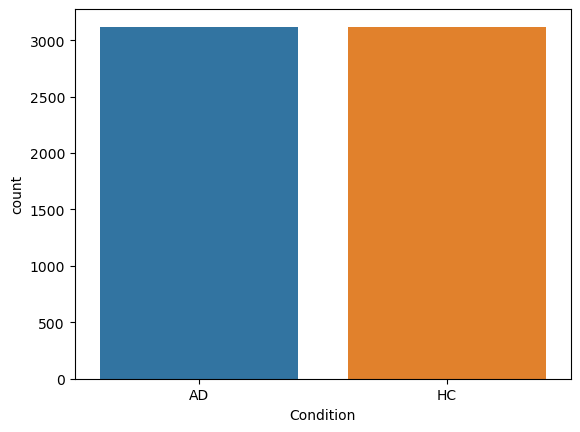

In [27]:
sns.countplot(df_usampling["Condition"])

In [28]:
# Binary enconding 
Y = df_usampling["Condition"].to_numpy()

l_encoder = LabelEncoder()
i_encoded = l_encoder.fit_transform(Y)

Y = i_encoded.reshape(1, -1).T
Y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [29]:
# Train and Test splitting 
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.2, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(   
#     X_train, y_train, test_size=0.1, random_state=42)

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


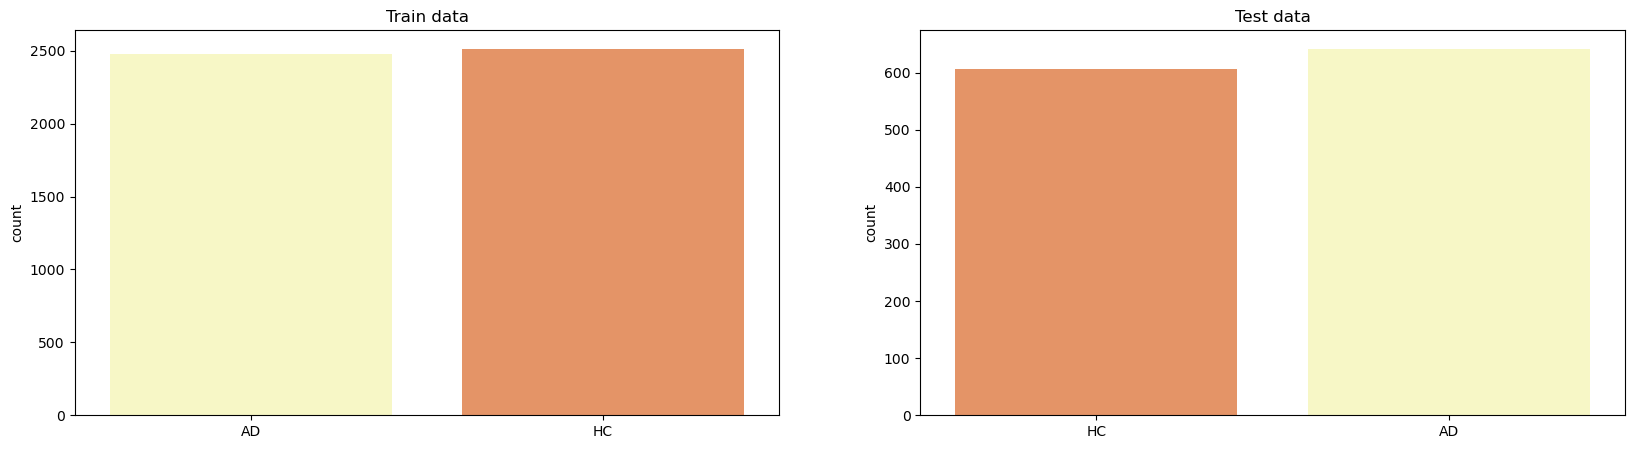

In [55]:
colors = sns.color_palette('Spectral', 3)
palette = {mode: color for mode, color in zip(["HC", "AD"], colors)}

fig, ax = plt.subplots(1,2,figsize=(20,5))


sns.countplot(l_encoder.inverse_transform(y_train.ravel()), ax=ax[0], palette=palette)
ax[0].set_title("Train data")

sns.countplot(l_encoder.inverse_transform(y_test.ravel()), ax=ax[1], palette=palette);
ax[1].set_title("Test data");

# Models

## Support Vector Machine 

In [30]:
X_train_reshape = X_train.reshape(X_train.shape[0],400)
X_test_reshape = X_test.reshape(X_test.shape[0],400)

In [ ]:
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [100], 'gamma': [0.1],'kernel': ['rbf']}

grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train_reshape,y_train)

0.8517628205128205


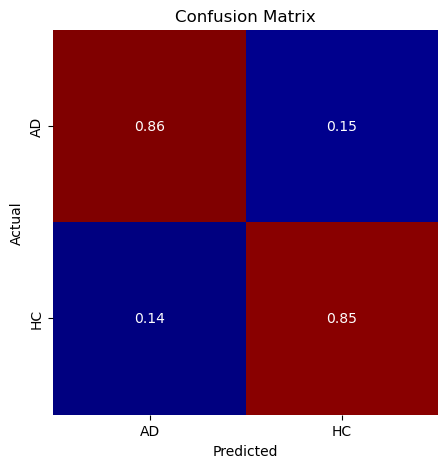

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       642
           1       0.85      0.85      0.85       606

    accuracy                           0.85      1248
   macro avg       0.85      0.85      0.85      1248
weighted avg       0.85      0.85      0.85      1248



In [43]:
y_pred=grid.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))

class_report = showClassficationReport(y_pred , y_test.T[0], ["AD", "HC"] )
print(class_report)


## Random Forest

C:\Users\jimmy\AppData\Local\Temp\ipykernel_4680\1198822935.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_reshape,y_train)


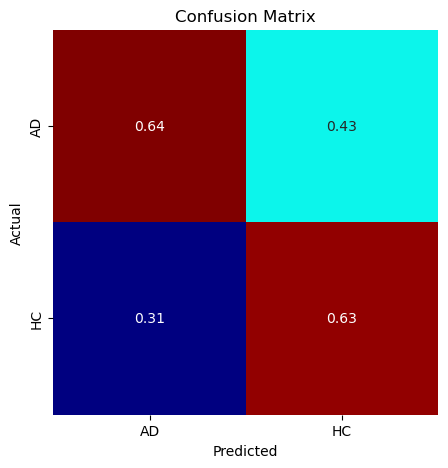

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       677
           1       0.59      0.63      0.61       571

    accuracy                           0.63      1248
   macro avg       0.63      0.63      0.63      1248
weighted avg       0.64      0.63      0.63      1248



In [54]:
# Random forest 

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_reshape,y_train)



y_pred = clf.predict(X_test_reshape)

accuracy_score(y_test, y_pred)
print(showClassficationReport(y_test, y_pred, ["AD", "HC"]))

## MLP 

In [ ]:
from sklearn.neural_network import MLPClassifier

parameter_space = {
    'hidden_layer_sizes': [(128,128,64)],
    'activation': ['relu'],
    'solver': ['lbfgs',],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [ 0.01]}

clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_reshape, y_train) # X is train samples and y is the corresponding labels

0.7860576923076923


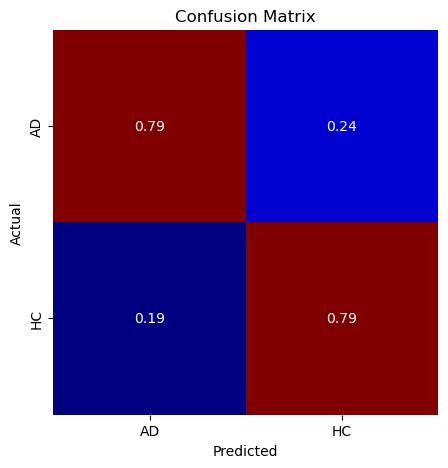

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       655
           1       0.77      0.79      0.78       593

    accuracy                           0.79      1248
   macro avg       0.79      0.79      0.79      1248
weighted avg       0.79      0.79      0.79      1248



In [46]:
y_pred = clf.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))
print(showClassficationReport(y_test, y_pred, ["AD", "HC"]))

## Deep Neural Network

In [ ]:
X = Variable(torch.from_numpy(X.astype(np.float32)), requires_grad=False)
Y = Variable(torch.from_numpy(Y.astype(np.float32)), requires_grad=False)

In [ ]:
tags_train = l_encoder.inverse_transform(y_train)
tags_test = l_encoder.inverse_transform(y_test)

In [ ]:
data_dist = {"train" : len(X_train), "test" : len(X_test), "val" : len(X_val)}
data_dist

{'train': 220, 'test': 56, 'val': 22}

In [ ]:
from torchsummary import summary

In [ ]:
# Network Initialization 

model = nn.Sequential(
          nn.Conv2d(1,16,3),
          nn.Conv2d(16,16,3),
          nn.MaxPool2d(2),
          nn.Dropout(),
          nn.Conv2d(16,32,3),
          nn.Conv2d(32,32,3),
          nn.MaxPool2d(3),
          nn.Dropout(),
          nn.Flatten(start_dim=0),
          nn.Linear(32, 160),
          nn.ReLU(),
          nn.Linear(160, 1),
          nn.Softmax(0)
        )
model.to("cuda")

#summary(model, (1,20,20))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=0, end_dim=-1)
  (9): Linear(in_features=32, out_features=160, bias=True)
  (10): ReLU()
  (11): Linear(in_features=160, out_features=1, bias=True)
  (12): Softmax(dim=0)
)

In [ ]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
validation_ds = torch.utils.data.TensorDataset(X_test, y_test)


train_ds_loader = torch.utils.data.DataLoader(train_ds,shuffle=True)
val_ds_loader = torch.utils.data.DataLoader(validation_ds,shuffle=True)

In [ ]:
import torch.optim as optim


loss_fn=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)

In [ ]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=0)
    #print(classes)
    return torch.mean((classes == labels).float())

In [ ]:
num_epoch = 30 
train_losses=[]
valid_losses=[]

for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0
a
  train_f1 =0.0
  train_acc = 0.0

  model.train()
  for img,lbl in train_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    optimizer.zero_grad()
    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    print((label, prediction))
    train_acc += accuracy_score(label, prediction)
    train_f1 += f1_score(label, prediction)

  model.eval()
  for img,lbl in val_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())

    valid_loss+=loss.item()*img.size(0)

  train_loss=train_loss/len(train_ds_loader.sampler) 
  valid_loss=valid_loss/len(val_ds_loader.sampler)

  train_acc=train_acc/train_f1
  
  train_f1=train_f1/len(val_ds_loader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} Train Accuracy:{:.4f} Train F1:{:.4f}'.format(epoch,train_loss,valid_loss, train_acc, train_f1))    

In [31]:
np.sum(np.isnan(X_train_reshape))

0

# Average matrices

In [434]:
hc_idx = list(np.where(df_usampling["Condition"] == "HC")[0])
ad_idx = list(np.where(df_usampling["Condition"] == "AD")[0])

In [435]:
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [436]:
for i in hc_idx: 
    corr_hc += X[i]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += X[i]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

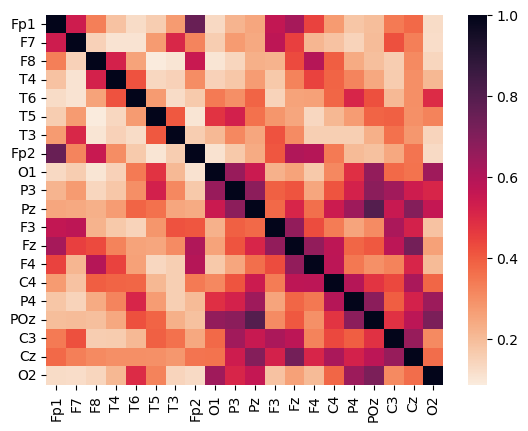

In [445]:
cmap = sns.cm.rocket_r

sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

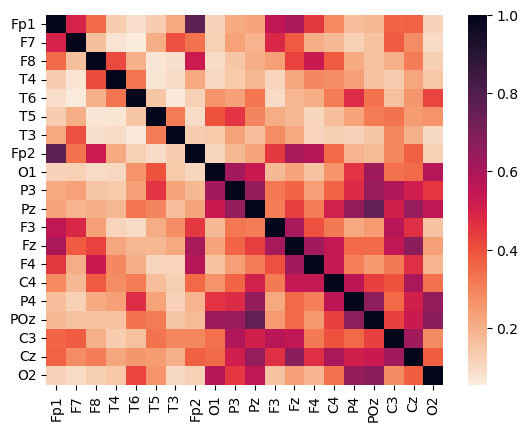

In [446]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

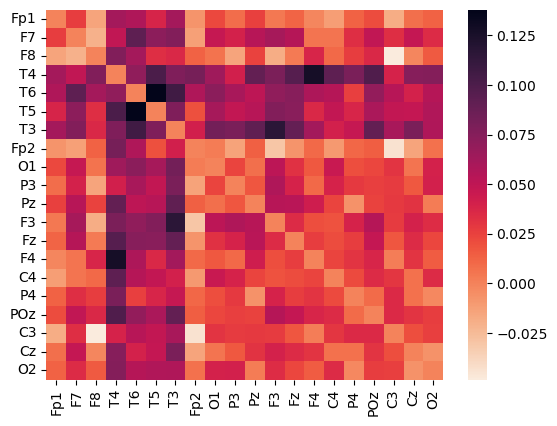

In [448]:
sns.heatmap((corr_hc-corr_ad), cmap=cmap, xticklabels=channels, yticklabels=channels)